In [1]:
import pickle

In [2]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [3]:
import csv

In [4]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [6]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
from tqdm import tqdm

In [8]:
from sklearn.metrics import classification_report

In [9]:
from scipy import stats

In [10]:
classes = ['Negative', 'Positive']

In [11]:
output_collections_list = []
for idx in range(0, 6000+1, 1000):
    with open("saved/score_42/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
#         print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

1000
1000
1000
1000
1000
1000
920


6920

In [12]:
data = []
for i in output_collections_list:
    data.append([i['index'], 
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], i['theta'], 
                 i['sentence'], i['label'], i['prediction'], i['prob'],
                 i['tokens'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['sample_index', 
                                   'influence_prime', 
                                   'influence', 
                                   'diff', 'theta', 
                                   'sentence', 'label', 'prediction', 'prob', 
                                   'tokens', 'attributions'
                                  ])

df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [13]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

5

In [14]:
df_0.loc[drop_index, 'influence'] = 0.0

In [15]:
def generate(text_list, attention_list, latex_file, color='red', rescale_value=False):
    text_list = text_list[1:-1]
    attention_list = attention_list[1:-1]
    assert(len(text_list) == len(attention_list))

    word_num = len(text_list)
    with open(latex_file,'w') as f:
        f.write(r'''\documentclass[varwidth]{standalone}
\special{papersize=210mm,297mm}
\usepackage{color}
\usepackage{tcolorbox}
\usepackage{CJK}
\usepackage{adjustbox}
\tcbset{width=0.9\textwidth,boxrule=0pt,colback=red,arc=0pt,auto outer arc,left=0pt,right=0pt,boxsep=5pt}
\begin{document}
\begin{CJK*}{UTF8}{gbsn}'''+'\n')
        string = r'''{\setlength{\fboxsep}{0pt}\colorbox{white!0}{\parbox{0.8\textwidth}{'''+"\n"
        
        for idx in range(word_num):
            if attention_list[idx] >= 0:
                color = 'red'
                string += "\\colorbox{%s!%s}{"%(color, attention_list[idx])+"\\strut " + text_list[idx]+"} "
            else:
                color = 'blue'
                string += "\\colorbox{%s!%s}{"%(color, -attention_list[idx])+"\\strut " + text_list[idx]+"} "
            
        string += "\n}}}"
        f.write(string+'\n')
        f.write(r'''\end{CJK*}
\end{document}''')

In [16]:
import matplotlib.colors as colors
import matplotlib.patches as patches

def plot(theta, label, prediction, tokens, attributions, idx):
    attributions = attributions / np.linalg.norm(attributions)
    
    generate(tokens, attributions*100, "saved/vis/sample_{}_{}.tex".format(label, idx), 'red')

    fig, ax = plt.subplots(1, 1, figsize=(int(len(tokens)*0.5), 1))
    
    x_label_list = tokens
    y_label_list = ['']
    ####
    u1 = (-attributions).argsort()[: 3]
    u2 = (attributions).argsort()[: 3]

#     print(u)
    v = 0
    attr_max = np.abs(attributions).max()
    
    norm = colors.DivergingNorm(vmin=-attr_max, vcenter=0, vmax=attr_max)

    img_1 = ax.imshow(attributions.reshape(1, -1), 
                      origin = 'lower', 
                      norm=norm,
                      cmap="coolwarm")

    ax.set_xticks(range(len(x_label_list)))
    ax.set_yticks(range(len(y_label_list)))

    ax.set_xticklabels(x_label_list, rotation=30, fontsize=8)
    ax.set_yticklabels(y_label_list)
    
    for idx, i in enumerate(u1):
        rect = patches.Rectangle((i-0.5,v-0.5), 1, 1, linewidth=1, edgecolor='gray',facecolor='none')
        ax.add_patch(rect)
        plt.text(i-0.25, v-0.25, str(idx+1), color='white', fontsize=12)
        
    for idx, i in enumerate(u2):
        rect = patches.Rectangle((i-0.5,v-0.5), 1, 1, linewidth=1, edgecolor='gray',facecolor='none')
        ax.add_patch(rect)
        plt.text(i-0.25, v-0.25, '-'+str(idx+1), color='white', fontsize=12)

    ax.set_title('Gold Label: ' + classes[label] + ' Prediction: ' + classes[prediction] + '\n' + 'Estimated Mem: ' + str(np.round(theta, 2)))

    plt.show()    

In [17]:
df_0_sorted = df_0.sort_values(by=['influence'], ascending=False) 
tmp = df_0_sorted[df_0_sorted['label']==0].head(5).reset_index(drop=True)

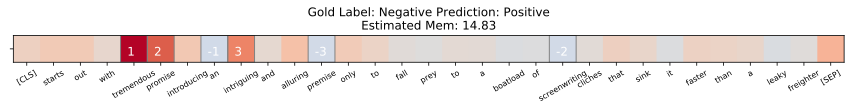

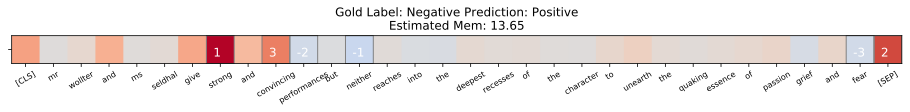

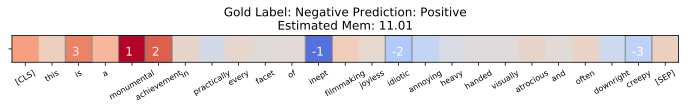

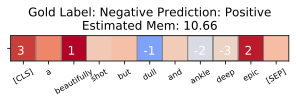

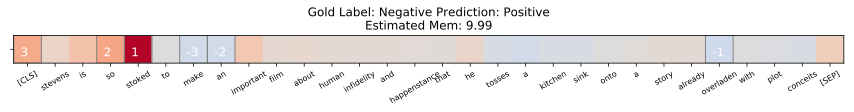

In [18]:
for idx, row in tmp.iterrows():
    theta=row['influence']
    gt=row['label']
    prob=row['prediction'] 
    
    tokens = row['tokens']
    attributions = row['attributions']
    words = []
    words_attributions = []
    for i, j in zip(tokens, attributions):
        if i[0:2]!='##':
            words.append(i)
            words_attributions.append(j)
        else:
            words[-1]+=i[2:]
            words_attributions[-1]+=j
                
#     print(row['theta'])
#     plot(tokens, attributions)
    plot(theta, gt, prob, words, words_attributions, idx)

In [19]:
df_0_sorted = df_0.sort_values(by=['influence'], ascending=False) 
tmp = df_0_sorted[df_0_sorted['label']==1].head(5).reset_index(drop=True)

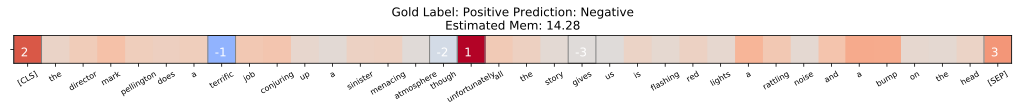

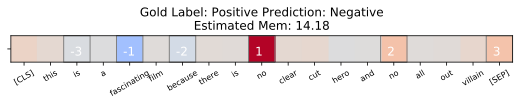

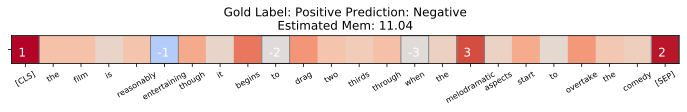

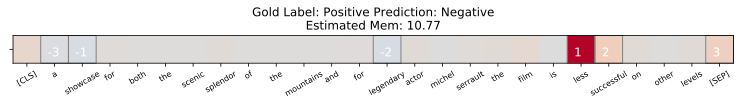

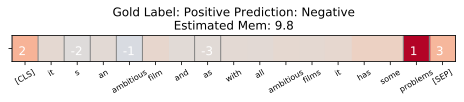

In [20]:
for idx, row in tmp.iterrows():
    theta=row['influence']
    gt=row['label']
    prob=row['prediction'] 
    
    tokens = row['tokens']
    attributions = row['attributions']
    words = []
    words_attributions = []
    for i, j in zip(tokens, attributions):
        if i[0:2]!='##':
            words.append(i)
            words_attributions.append(j)
        else:
            words[-1]+=i[2:]
            words_attributions[-1]+=j
                
#     print(row['theta'])
#     plot(tokens, attributions)
    plot(theta, gt, prob, words, words_attributions, idx)